In [194]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv

# F5C output
The F5C command we have used is 
- f5c eventalign --print-read-names --signal-index --collapse-events --scale-events --samples -b ./4_basecalls_bam/reverse_1_sorted.bam -g reference.fa -r ./3_basecalls_fa/reverse-1.fa --pore r10 > ./5_aligned_events/events_reverese_1_unscaled_id_collapse.tsv'

r1_scaled is the output of the F5C $\textit{eventalign}$ call above. It contains aligned and collapsed events, which are scaled to the model.
- $\textbf{Aligned}$: This means that each event is matched up with a 9mer in the reference sequence.  
- $\textbf{Collapsed}$: Some 9mers will have multiple events associated with them. $\textit{Collapsed}$ means that events corresponding to a single 9mer are aggregated into a single row of the F5C output file.
- $\textbf{Scaled}$: Each read is individually shifted and scaled so that it more closely matches the model means and standard deviation. This means the 'event_level_mean' and 'samples' in the table below are not the original current levels, but the scaled version. These columns now comparable across reads. 
Below is an excerpt of the F5C output.

In [195]:
r1_scaled = pd.read_csv('./5_aligned_events/events_reverse_1_scaled_id_collapse.tsv', delimiter='\t') # please ignore the 'unscaled' in the file name. This is indeed the scaled version
r1_scaled.head(3)

,contig,position,reference_kmer,read_name,strand,event_index,event_level_mean,event_stdv,event_length,model_kmer,model_mean,model_stdv,standardized_level,start_idx,end_idx,samples
0,reverse_1,1,TTGTCGGAT,0d9274ec-cb72-4141-b3b0-ec63d4cdd4b5,t,114,64.96,2.309,0.0018,TTGTCGGAT,66.65,6.51,-0.32,533,542,"64.329,66.4671,65.992,62.4284,67.1798,62.9036,..."
1,reverse_1,2,TGTCGGATT,0d9274ec-cb72-4141-b3b0-ec63d4cdd4b5,t,115,61.21,3.497,0.0016,TGTCGGATT,63.53,4.90,-0.58,542,550,"60.0528,58.6273,56.9644,60.2903,62.9036,60.052..."
2,reverse_1,3,GTCGGATTC,0d9274ec-cb72-4141-b3b0-ec63d4cdd4b5,t,117,125.74,1.786,0.0016,GTCGGATTC,117.03,16.98,0.63,550,558,"124.909,121.583,127.522,125.147,127.285,125.38..."


Some of the columns are not relevant, so we remove them. The following rows are the beginning of the first read.

In [196]:
r1_scaled = r1_scaled[['position', 'reference_kmer','read_name','event_index','event_level_mean','event_stdv','event_length','model_mean','model_stdv','standardized_level']]
r1_scaled.head(5)

,position,reference_kmer,read_name,event_index,event_level_mean,event_stdv,event_length,model_mean,model_stdv,standardized_level
0,1,TTGTCGGAT,0d9274ec-cb72-4141-b3b0-ec63d4cdd4b5,114,64.96,2.309,0.0018,66.65,6.51,-0.32
1,2,TGTCGGATT,0d9274ec-cb72-4141-b3b0-ec63d4cdd4b5,115,61.21,3.497,0.0016,63.53,4.90,-0.58
2,3,GTCGGATTC,0d9274ec-cb72-4141-b3b0-ec63d4cdd4b5,117,125.74,1.786,0.0016,117.03,16.98,0.63
3,4,TCGGATTCG,0d9274ec-cb72-4141-b3b0-ec63d4cdd4b5,118,127.41,2.302,0.0066,126.53,4.88,0.22
4,5,CGGATTCGT,0d9274ec-cb72-4141-b3b0-ec63d4cdd4b5,123,111.66,2.863,0.0050,110.97,5.52,0.15


Notes for this first read:
- Event index starts at 114 because first 113 events are garbage, which are ignored during alignment.
- Second and third event_index differ by 2. This is because two events correspond to the second kmer TGTCGGATT, and these are collapsed into a single row.

Now we will look at a single kmer - consider TGTCGGATT which is at position 2.

In [197]:
r1_pos2 = r1_scaled[r1_scaled.position == 3]
r1_pos2.head(5)

,position,reference_kmer,read_name,event_index,event_level_mean,event_stdv,event_length,model_mean,model_stdv,standardized_level
2,3,GTCGGATTC,0d9274ec-cb72-4141-b3b0-ec63d4cdd4b5,117,125.74,1.786,0.0016,117.03,16.98,0.63
167,3,GTCGGATTC,0e7fe863-c231-45c3-a786-bd3d62a4329c,103,124.91,1.896,0.0010,117.03,16.98,0.56
321,3,GTCGGATTC,0f4ad5d7-37e3-4357-9773-fa77f5c63038,111,121.41,4.224,0.0018,117.03,16.98,0.30
492,3,GTCGGATTC,1398d546-c48d-4bf6-bf0a-4228cc1bebe3,104,121.45,3.941,0.0006,117.03,16.98,0.31
654,3,GTCGGATTC,16807324-ae33-41d7-a74d-2915d6731bd0,109,121.95,3.832,0.0018,117.03,16.98,0.36


Notes for this kmer:
- read_name column indicates that we are looking across many reads now. 
- Model mean/stdv is equal for all these reads, because we have scaled the events to the model using the --scaling-events tag.

Now consider the standardised level

In [198]:
r1_pos2.loc[:,'z-score'] = (r1_pos2['event_level_mean'] - r1_pos2['model_mean']) / r1_pos2['model_stdv']
r1_pos2.head(5)


C:\Users\preet\AppData\Local\Temp\ipykernel_69640\1895730786.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r1_pos2.loc[:,'z-score'] = (r1_pos2['event_level_mean'] - r1_pos2['model_mean']) / r1_pos2['model_stdv']


,position,reference_kmer,read_name,event_index,event_level_mean,event_stdv,event_length,model_mean,model_stdv,standardized_level,z-score
2,3,GTCGGATTC,0d9274ec-cb72-4141-b3b0-ec63d4cdd4b5,117,125.74,1.786,0.0016,117.03,16.98,0.63,0.512956
167,3,GTCGGATTC,0e7fe863-c231-45c3-a786-bd3d62a4329c,103,124.91,1.896,0.0010,117.03,16.98,0.56,0.464075
321,3,GTCGGATTC,0f4ad5d7-37e3-4357-9773-fa77f5c63038,111,121.41,4.224,0.0018,117.03,16.98,0.30,0.257951
492,3,GTCGGATTC,1398d546-c48d-4bf6-bf0a-4228cc1bebe3,104,121.45,3.941,0.0006,117.03,16.98,0.31,0.260306
654,3,GTCGGATTC,16807324-ae33-41d7-a74d-2915d6731bd0,109,121.95,3.832,0.0018,117.03,16.98,0.36,0.289753


The standardized_level is not simply equal to the z-score. There is a scaling given by
$${standardized\_level} = {z\_score}\times \frac{1}{\sqrt{{var}}}$$
$var$ is an indicator of how bad the scaling and shifting step for each read was. A var of 0 indicates a perfect scaling, while a var of 1 is worst.

The method used to calculate var, and its purpose, is somewhat unclear, so we avoid this for the time being.

We want to find the consensus event_level_mean for TGTCGGATT for a set of $n$ reads. From the table above, we can find for each read a event_level_mean, $\mu_i$, event_stdv, $\sigma_i$ and an event_length, $T_i$.  One method is to take the simple average.
$$\mu_\text{simple}=\frac{\sum_{i=1}^n \mu_i}{n}.$$

In [199]:
consensus_pos2_simple = r1_pos2['event_level_mean'].mean()
print(f'Simple method: consensus current level for TGTCGGATT is {consensus_pos2_simple:.2f} pA')

Simple method: consensus current level for TGTCGGATT is 119.45 pA


We notice that some reads have longer or more events than other reads. We can calculate a more sophisticated average by weighting using the event_length.
$$\mu_\text{weight1}=\frac{\sum_{i=1}^n \mu_iT_i}{\sum_{i=1}^n T_i}.$$

In [200]:
consensus_pos2_weighted = (r1_pos2['event_level_mean'] * r1_pos2['event_length']).sum() / (r1_pos2['event_length']).sum()
print(f'Weighted method: consensus current level for TGTCGGATT is {consensus_pos2_weighted:.2f} pA')

Weighted method: consensus current level for TGTCGGATT is 117.87 pA


This is not much different. A further level of sophistication can be brought by weighting inversely by the event_stdv. The idea behind this is that a read with more standard deviation for a given 9mer is less reliable, and should have a smaller influence.
$$\mu_\text{weight2}=\frac{\sum_{i=1}^n \mu_iT_i/\sigma_i}{\sum_{i=1}^n T_i/\sigma_i}.$$

In [201]:

std = np.maximum(r1_pos2['event_stdv'],0.01)
consensus_pos2_weighted_2 = (r1_pos2['event_level_mean'] * r1_pos2['event_length'] / std).sum() / (r1_pos2['event_length'] / (std)).sum()
print(f'Second weighted method: consensus current level for TGTCGGATT is {consensus_pos2_weighted_2:.2f} pA')

Second weighted method: consensus current level for TGTCGGATT is 122.59 pA


This seems to have a larger impact on the result. Indeed, if we plot the event_level_mean against the event_stdv, we see the following.

(65.0, 135.0)

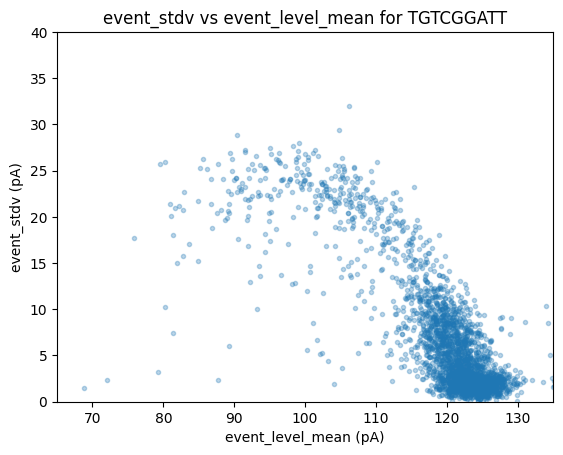

In [202]:
plt.scatter(r1_pos2['event_level_mean'], r1_pos2['event_stdv'], marker='.', alpha=0.3);
plt.title('event_stdv vs event_level_mean for TGTCGGATT')
plt.xlabel('event_level_mean (pA)')
plt.ylabel('event_stdv (pA)');
plt.ylim((0, 40))
plt.xlim((65, 135))

(0.0, 25.0)

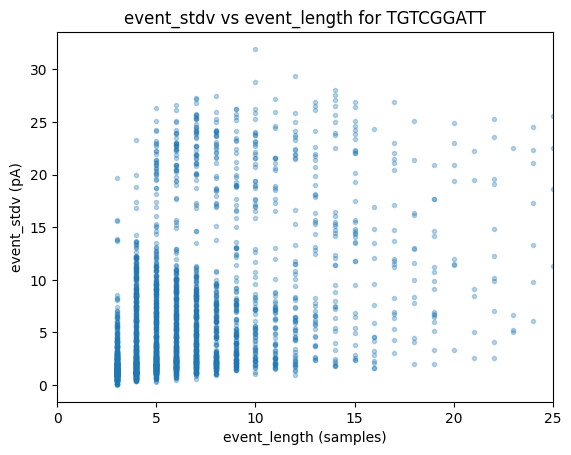

In [203]:
plt.scatter(r1_pos2['event_length']*5000, r1_pos2['event_stdv'], marker='.', alpha=0.3);
plt.title('event_stdv vs event_length for TGTCGGATT')
plt.xlabel('event_length (samples)')
plt.ylabel('event_stdv (pA)');
plt.xlim((0,25))

This plot shows a surprising relationship. We are looking at the 9mer TGTCGGATT across all reads. In reads where the event_level_mean is higher, we see that event_stdv is also higher. These uncertain reads were previously skewing our mean, but the second weighted method adjusts for this. 

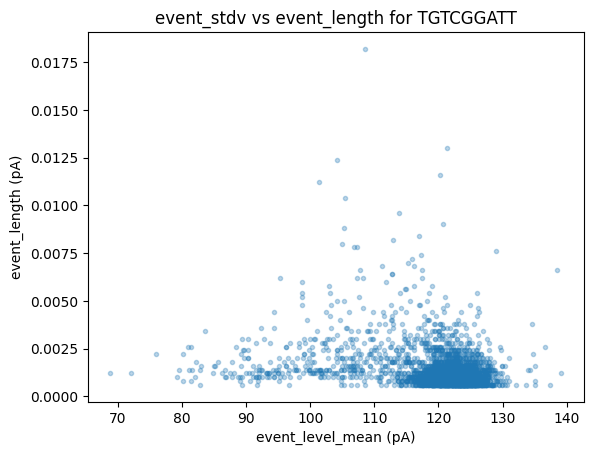

In [204]:
plt.scatter(r1_pos2['event_level_mean'], r1_pos2['event_length'], marker='.', alpha=0.3);
plt.title('event_stdv vs event_length for TGTCGGATT')
plt.xlabel('event_level_mean (pA)')
plt.ylabel('event_length (pA)');